Mean average precision: 0.9066


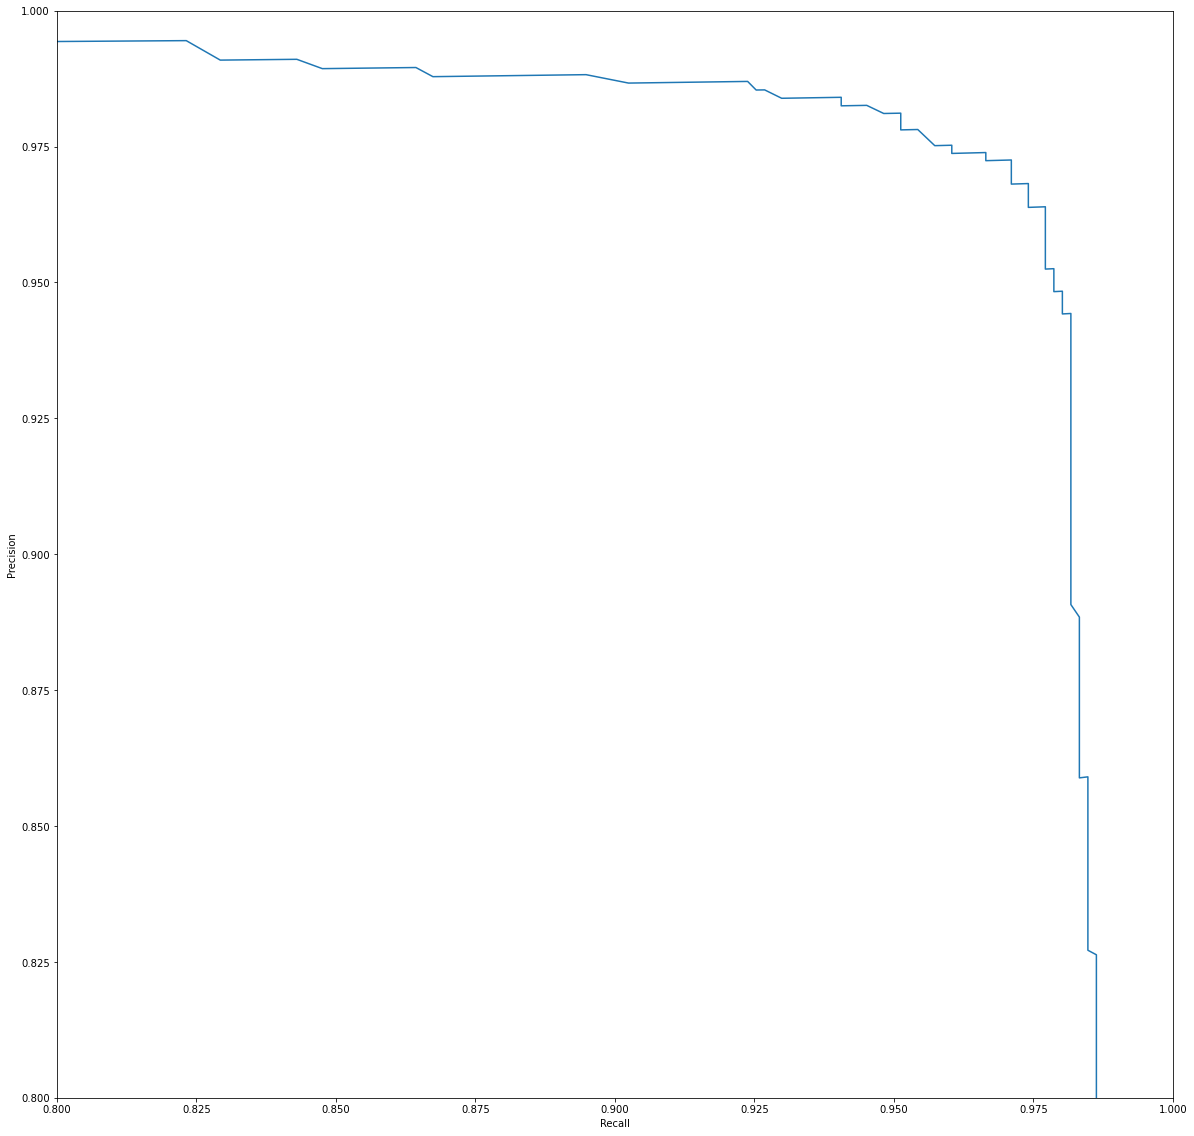

In [3]:
import matplotlib.pyplot as plt
from tools import read_predicted_boxes, read_ground_truth_boxes


def calculate_iou(prediction_box, gt_box):
    """Calculate intersection over union of single predicted and ground truth box.

    Args:
        prediction_box (np.array of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (np.array of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]

        returns:
            float: value of the intersection of union for the two boxes.
    """
    # YOUR CODE HERE

    # Compute intersection
    x_left = max(gt_box[0], prediction_box[0])
    y_bottom = max(gt_box[1], prediction_box[1])
    x_right = min(gt_box[2], prediction_box[2])
    y_top = min(gt_box[3], prediction_box[3])
    Area_intersection = max(0, x_right - x_left) * max(0, y_top - y_bottom)

    # Compute union
    Area_box1 = (prediction_box[2]-prediction_box[0])*(prediction_box[3]-prediction_box[1])
    Area_box2 = (gt_box[2]-gt_box[0])*(gt_box[3]-gt_box[1])
    iou = Area_intersection / float(Area_box2 + Area_box1 - Area_intersection)
    assert iou >= 0 and iou <= 1
    return iou


def calculate_precision(num_tp, num_fp, num_fn):
    """ Calculates the precision for the given parameters.
        Returns 1 if num_tp + num_fp = 0

    Args:
        num_tp (float): number of true positives
        num_fp (float): number of false positives
        num_fn (float): number of false negatives
    Returns:
        float: value of precision
    """
    try:
        prec = num_tp / (num_tp + num_fp)
        
    except ZeroDivisionError:
        prec = 1.0
        
    return prec


def calculate_recall(num_tp, num_fp, num_fn):
    """ Calculates the recall for the given parameters.
        Returns 0 if num_tp + num_fn = 0
    Args:
        num_tp (float): number of true positives
        num_fp (float): number of false positives
        num_fn (float): number of false negatives
    Returns:
        float: value of recall
    """
    try:
        rec = num_tp / (num_tp + num_fn)
        
    except ZeroDivisionError:
        rec = 0.0
        
    return rec


def get_all_box_matches(prediction_boxes, gt_boxes, iou_threshold):
    """Finds all possible matches for the predicted boxes to the ground truth boxes.
        No bounding box can have more than one match.

        Remember: Matching of bounding boxes should be done with decreasing IoU order!

    Args:
        prediction_boxes: (np.array of floats): list of predicted bounding boxes
            shape: [number of predicted boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
        gt_boxes: (np.array of floats): list of bounding boxes ground truth
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
    Returns the matched boxes (in corresponding order):
        prediction_boxes: (np.array of floats): list of predicted bounding boxes
            shape: [number of box matches, 4].
        gt_boxes: (np.array of floats): list of bounding boxes ground truth
            objects with shape: [number of box matches, 4].
            Each row includes [xmin, ymin, xmax, ymax]
    """
    # Find all possible matches with a IoU >= iou threshold
    pred_matches, gt_matches = [], []
    for gt in gt_boxes:
        prediction_box, max_iou = None, 0
        for pred in prediction_boxes:
            iou = calculate_iou(pred,gt)
            if (iou >= iou_threshold):
                if (iou > max_iou):
                    "Best prediction so far"
                    prediction_box, max_iou = pred, iou
        if prediction_box is not None:
                pred_matches.append(prediction_box)
                gt_matches.append(gt)
    
    return np.array(pred_matches), np.array(gt_matches)





def calculate_individual_image_result(prediction_boxes, gt_boxes, iou_threshold):
    """Given a set of prediction boxes and ground truth boxes,
       calculates true positives, false positives and false negatives
       for a single image.
       NB: prediction_boxes and gt_boxes are not matched!

    Args:
        prediction_boxes: (np.array of floats): list of predicted bounding boxes
            shape: [number of predicted boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
        gt_boxes: (np.array of floats): list of bounding boxes ground truth
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
    Returns:
        dict: containing true positives, false positives, true negatives, false negatives
            {"true_pos": int, "false_pos": int, false_neg": int}
    """
    
    pred_matches, gt_matches = get_all_box_matches(prediction_boxes, gt_boxes, iou_threshold)
    individual_image_result = {"true_pos": len(pred_matches), "false_pos": len(prediction_boxes) - len(pred_matches), "false_neg": len(gt_boxes) - len(gt_matches)}
    
    return individual_image_result
    
    


def calculate_precision_recall_all_images(
    all_prediction_boxes, all_gt_boxes, iou_threshold):
    """Given a set of prediction boxes and ground truth boxes for all images,
       calculates recall and precision over all images
       for a single image.
       NB: all_prediction_boxes and all_gt_boxes are not matched!

    Args:
        all_prediction_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all predicted bounding boxes for the given image
            with shape: [number of predicted boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
        all_gt_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all ground truth bounding boxes for the given image
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
    Returns:
        tuple: (precision, recall). Both float.
    """

    num = {"tp": 0, "fp": 0, "fn": 0}
    for pred, gt in zip(all_prediction_boxes, all_gt_boxes):
        individual_image_result = calculate_individual_image_result(pred, gt, iou_threshold)
        
        num["tp"] += individual_image_result["true_pos"]
        num["fp"] += individual_image_result["false_pos"]
        num["fn"] += individual_image_result["false_neg"]      
    precision, recall = calculate_precision(num["tp"], num["fp"], num["fn"]), calculate_recall(num["tp"], num["fp"], num["fn"])
    return (precision, recall)

def get_precision_recall_curve(
    all_prediction_boxes, all_gt_boxes, confidence_scores, iou_threshold
):
    """Given a set of prediction boxes and ground truth boxes for all images,
       calculates the recall-precision curve over all images.
       for a single image.

       NB: all_prediction_boxes and all_gt_boxes are not matched!

    Args:
        all_prediction_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all predicted bounding boxes for the given image
            with shape: [number of predicted boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
        all_gt_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all ground truth bounding boxes for the given image
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
        scores: (list of np.array of floats): each element in the list
            is a np.array containting the confidence score for each of the
            predicted bounding box. Shape: [number of predicted boxes]

            E.g: score[0][1] is the confidence score for a predicted bounding box 1 in image 0.
    Returns:
        precisions, recalls: two np.ndarray with same shape.
    """
    
    confidence_thresholds = np.linspace(0, 1, 500)

    precisions, recalls = [], []
    for threshold in confidence_thresholds:
        prediction_box = []
        for pred_box, scores in zip(all_prediction_boxes, confidence_scores):
            image_pred_boxes  = []
            image_pred_boxes  = [b for i,b in enumerate(pred_box ,0) if threshold<=scores[i]]
            prediction_box.append(image_pred_boxes)
        prec = calculate_precision_recall_all_images(prediction_box, all_gt_boxes, iou_threshold)[0]
        rec = calculate_precision_recall_all_images(prediction_box, all_gt_boxes, iou_threshold)[1]
        precisions.append(prec)
        recalls.append(rec)
    return np.array(precisions), np.array(recalls)



def plot_precision_recall_curve(precisions, recalls):
    """Plots the precision recall curve.
        Save the figure to precision_recall_curve.png:
        'plt.savefig("precision_recall_curve.png")'

    Args:
        precisions: (np.array of floats) length of N
        recalls: (np.array of floats) length of N
    Returns:
        None
    """
    plt.figure(figsize=(20, 20))
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0.8, 1.0])
    plt.ylim([0.8, 1.0])
    plt.savefig("precision_recall_curve.png")


def calculate_mean_average_precision(precisions, recalls):
    """ Given a precision recall curve, calculates the mean average
        precision.

    Args:
        precisions: (np.array of floats) length of N
        recalls: (np.array of floats) length of N
    Returns:
        float: mean average precision
    """
    # Calculate the mean average precision given these recall levels.
    recall_levels = np.linspace(0, 1.0, 11)
    # YOUR CODE HERE
    average_precision, max_precision = 0, 0
    for i in recall_levels:
        for prec, rec in zip(precisions, recalls):
            if (prec > max_precision):
                if (rec >= i):
                    max_precision = prec
        average_precision += max_precision/11
        max_precision = 0

    return average_precision
    

def mean_average_precision(ground_truth_boxes, predicted_boxes):
    """ Calculates the mean average precision over the given dataset
        with IoU threshold of 0.5

    Args:
        ground_truth_boxes: (dict)
        {
            "img_id1": (np.array of float). Shape [number of GT boxes, 4]
        }
        predicted_boxes: (dict)
        {
            "img_id1": {
                "boxes": (np.array of float). Shape: [number of pred boxes, 4],
                "scores": (np.array of float). Shape: [number of pred boxes]
            }
        }
    """
    # DO NOT EDIT THIS CODE
    all_gt_boxes = []
    all_prediction_boxes = []
    confidence_scores = []

    for image_id in ground_truth_boxes.keys():
        pred_boxes = predicted_boxes[image_id]["boxes"]
        scores = predicted_boxes[image_id]["scores"]

        all_gt_boxes.append(ground_truth_boxes[image_id])
        all_prediction_boxes.append(pred_boxes)
        confidence_scores.append(scores)

    precisions, recalls = get_precision_recall_curve(
        all_prediction_boxes, all_gt_boxes, confidence_scores, 0.5)
    plot_precision_recall_curve(precisions, recalls)
    mean_average_precision = calculate_mean_average_precision(precisions, recalls)
    print("Mean average precision: {:.4f}".format(mean_average_precision))


if __name__ == "__main__":
    ground_truth_boxes = read_ground_truth_boxes()
    predicted_boxes = read_predicted_boxes()
    mean_average_precision(ground_truth_boxes, predicted_boxes)
